overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    explored_models_20200430 as param_iterator_obj_smaller_training_data,
    explored_models_20200520 as param_iterator_obj_more_cls,
    explored_models_20200616 as param_iterator_obj_even_more_cls,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
strategy_to_try_dict = {
    # plus the original (which should be equal to cummean)
    'original': None,
    'instant': {
        'mode': 'instant',
    },
    'instant-1': {
        'mode': 'instant',
        # by default it's -1
        'eval_pick': -2,
    },
    # for debugging.
    'cummean': {
        'mode': 'cummean',
    },
    'cummean-1': {
        'mode': 'cummean',
        'eval_pick': -2,
    },
    
    #
    'cummean-2nd': {
        'mode': 'cummean',
        'order': 2,
    },
    'cummean-2nd-drop1': {
        'mode': 'cummean',
        'order': 2,
        'drop': 1,
    },
    
}

In [7]:
from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

In [8]:
# copied from maskcnn_polished_with_rcnn_k_bl/store_response_for_20200218.ipynb

from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]


def evaluate_one_model_using_one_strategy(datasets_test, model, param, loss_type):
    
    # set model param
    model.moduledict['accumulator'].mode = param['mode']
    model.moduledict['accumulator'].order = param.get('order', 1)
    model.moduledict['accumulator'].drop = param.get('drop', 0)
    
    result_on_the_go = eval_wrapper(model,
                                    datasets_test,
                                    'cuda',
                                    1,
                                    partial(eval_fn_wrapper_neural, loss_type=loss_type, yhat_reduce_axis=1,
                                            yhat_reduce_pick=param.get('eval_pick', -1)),
                                    (lambda dummy1,dummy2,dummy3: torch.tensor(0.0)),
                                    return_responses=False,
                                   )
    ret = np.asarray(result_on_the_go['corr'])
    return ret

In [9]:
def load_everything():
    _df_collect = []
    done_ct = 0
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
            param_iterator_obj_smaller_training_data().generate(),
            param_iterator_obj_more_cls().generate(),
            param_iterator_obj_even_more_cls().generate(),
        )
    ):
        if idx % 20 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue
        
        if param['rcnn_bl_cls'] < 4:
            continue

            

        if len(param) == 22:
            param['train_keep'] = None
        assert len(param) == 23
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        assert param['rcnn_acc_type'] == 'cummean'
        
        
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120

        model = result['model']
        model.cuda()
        model.eval()


        datasets = get_data_cached(param['input_size'], param['split_seed'])


        datasets = {
            'X_train': datasets[0].astype(np.float32),
            'y_train': datasets[1],
            'X_val': datasets[2].astype(np.float32),
            'y_val': datasets[3],
            'X_test': datasets[4].astype(np.float32),
            'y_test': datasets[5],
        }

        # only the test one is needed.
        datasets_test = generate_datasets(
            **datasets,
            per_epoch_train=False,
            shuffle_train=False,
        )['test']
    
        
        
        for strategy, strategy_params in strategy_to_try_dict.items():
            if strategy == 'original':
                cc_raw_this = cc_raw
            else:
                cc_raw_this = evaluate_one_model_using_one_strategy(datasets_test, model, strategy_params, param['loss_type'])
            assert cc_raw_this.shape == (79,)
            _df_collect.append(
                {
                    'train_keep': param['train_keep'],
                    'act_fn': param['act_fn'],
                    'loss_type': param['loss_type'],
                    'scale': float(param['scale']),
                    'smoothness': float(param['smoothness']),
                    'num_layer': param['num_layer'],
                    'out_channel': param['out_channel'],
                    # 4 to go.
                    '1st_bn_before_act': param['ff_1st_bn_before_act'],
                    'rcnn_bl_cls': param['rcnn_bl_cls'],

                    'model_seed': param['model_seed'],
                    'strategy': strategy,
                    # done,
                    'corr_test': ((cc_raw_this/cc_max_all_neurons)**2).mean(),
                }
            )
        
        done_ct+=1
#         if done_ct >= 10:
#             break
    print('total', done_ct)
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'strategy',
        'corr_test',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'strategy',
    ], verify_integrity=True)
    return _df

In [10]:
df = load_everything()

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
total 2016


In [11]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

In [21]:
from scipy.stats import pearsonr

In [22]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    assert x.shape == y.shape == (x.size,)
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())
    print('r', pearsonr(x, y))

In [23]:
corr_mean.unstack('strategy')

strategy                                                                                             cummean  \
train_keep act_fn   loss_type scale smoothness num_layer out_channel 1st_bn_before_act rcnn_bl_cls             
1280       relu     mse       0.01  0.000005   2         8           False             4            0.401336   
                                                                                       5            0.386457   
                                                                                       6            0.367851   
                                                                                       7            0.357211   
                                                                                       8            0.367306   
...                                                                                                      ...   
5120       softplus poisson   0.01  0.000005   3         32          True              6            0.678661   
                                                                                       7            0.674330   
                                                                                       8            0.682788   
                                                                                       9            0.680163   
                                                                                       10           0.681309   

strategy                                                                                            cummean-1  \
train_keep act_fn   loss_type scale smoothness num_layer out_channel 1st_bn_before_act rcnn_bl_cls              
1280       relu     mse       0.01  0.000005   2         8           False             4             0.400444   
                                                                                       5             0.388243   
                                                                                       6             0.370313   
                                                                                       7             0.360547   
                                                                                       8             0.369945   
...                                                                                                       ...   
5120       softplus poisson   0.01  0.000005   3         32          True              6             0.679523   
                                                                                       7             0.675553   
                                                                                       8             0.684092   
                                                                                       9             0.681763   
                                                                                       10            0.682665   

strategy                                                                                            cummean-2nd  \
train_keep act_fn   loss_type scale smoothness num_layer out_channel 1st_bn_before_act rcnn_bl_cls                
1280       relu     mse       0.01  0.000005   2         8           False             4               0.396236   
                                                                                       5               0.382950   
                                                                                       6               0.365678   
                                                                                       7               0.357471   
                                                                                       8               0.368276   
...                                                                                                         ...   
5120       softplus poisson   0.01  0.000005   3         32          True              6               0.674989   
                                      

In [24]:
# 
# df.to_pickle('basic_for_20200218ksize3+20200430+20200520_20200616_cc2normed_check_different_agg_strategy.pkl')

In [25]:
def check_all_strategy():
    for st_this in strategy_to_try_dict.keys():
        if st_this == 'original':
            continue
        scatter(corr_mean.unstack('strategy')['original'].values, 
                corr_mean.unstack('strategy')[st_this].values,
                'original',
                st_this,
                f'agg strategy {st_this} vs original (cummean)',
               )

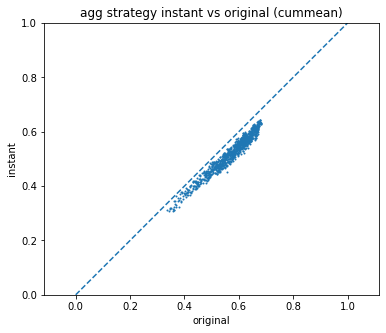

y-x mean -0.04937025982489836 y-x>0 mean 0.0
y top 0.6423722169006415 x top 0.6827881596407684
r (0.9773929468672955, 0.0)


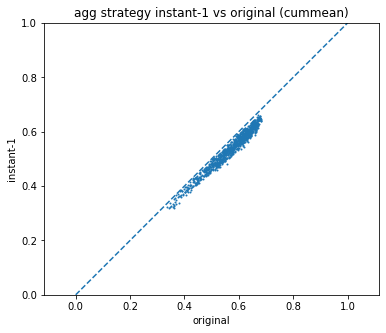

y-x mean -0.032074008819839815 y-x>0 mean 0.0
y top 0.6598060493383835 x top 0.6827881596407684
r (0.9828454822549471, 0.0)


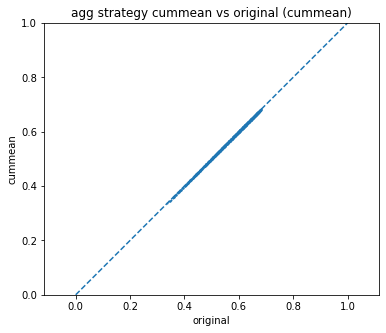

y-x mean -2.9197967071022234e-11 y-x>0 mean 0.4642857142857143
y top 0.6827881599433009 x top 0.6827881596407684
r (0.9999999999999996, 0.0)


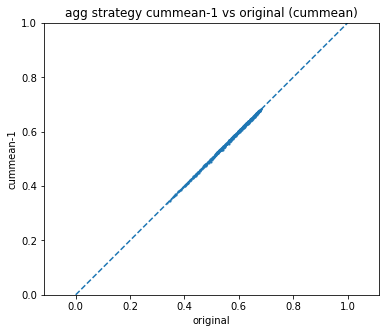

y-x mean 0.001285753386468273 y-x>0 mean 0.8363095238095238
y top 0.6840918888633167 x top 0.6827881596407684
r (0.9996927212884152, 0.0)


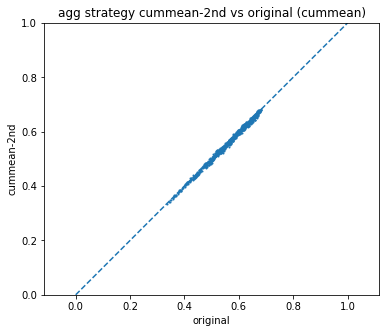

y-x mean -0.0016564771750936455 y-x>0 mean 0.3898809523809524
y top 0.6826376845292585 x top 0.6827881596407684
r (0.9974230806615338, 0.0)


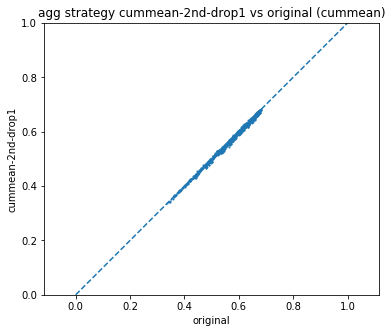

y-x mean -0.001731487269849334 y-x>0 mean 0.3878968253968254
y top 0.6822921868303031 x top 0.6827881596407684
r (0.9981053523415933, 0.0)


In [26]:
check_all_strategy()